In [4785]:
import torch
from torch.utils.data import DataLoader # loads data either in chunks or full
import torch.nn.functional as F
from torchvision import datasets # open datasets
from torchvision.transforms import ToTensor # transfor data to tensor
import matplotlib.pyplot as plt
import math

In [4786]:
# choosing gpu for training
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [4787]:
# download training and test data from open datasets.
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4788]:
# loading the data
train_dataloader = DataLoader(train_data, batch_size=64) # goes over 938 batches of 64
test_dataloader = DataLoader(test_data, batch_size=64)

Name: Shirt, Number: 6


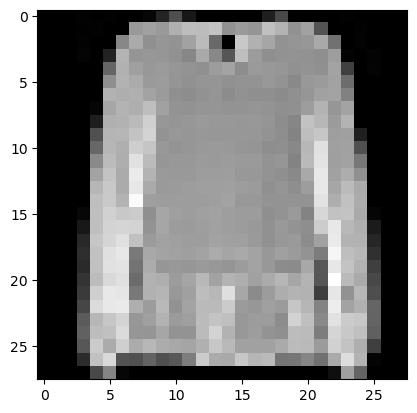

In [4816]:
# plotting and understanding images and labels with first batch

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

images, labels = next(iter(train_dataloader))
idx = torch.randint(0, 64, (1,)).item()
image = images[idx].squeeze()
label = labels[idx]
print(f"Name: {labels_map[label.item()]}, Number: {label.item()}")
plt.imshow(image, cmap="grey")
plt.show()

In [4790]:
class Layer: 
    # nin is the number of input (prev layer)
    # nout is the number of output (next layer)
    def __init__(self, nin, nout, processor="cuda:0"):
        self.w = torch.randn((nin, nout), requires_grad=True, device=processor)
        self.b = torch.randn(1, requires_grad=True, device=processor)
    
    # x is the input in (batch, input)
    def __call__(self, x):
        eq = torch.matmul(x, self.w) + self.b
        out = torch.tanh(eq)
        return out # returns (batch, output # of neurons for next layer)
    
    def parameters(self):
        return [self.w, self.b]
    
class MLP:
    def __init__(self, nin, nouts, lr, processor="cuda:0"):
        self.lr = lr
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return torch.softmax(x, dim=1)
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def update_parameters(self):
        with torch.no_grad():
            for param in self.parameters():
                if param is not None:
                    param -= param.grad * self.lr
                    param.grad.zero_()


In [4791]:
def test(mlp):
    tot = 0
    correct = 0

    tot = 0
    correct = 0

    with torch.no_grad():
        for test_x, test_y in test_dataloader:
            test_x, test_y = test_x.to("cuda:0"), test_y.to("cuda:0")

            test_x_flattened = test_x.view(test_x.size(0), -1)
            output = mlp(test_x_flattened)
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(test_y.view_as(pred)).sum().item()
            tot += test_y.size(0)

    accuracy = correct / tot * 100
    print(f"Test Accuracy: {accuracy:.2f}%\n")

In [4792]:
def train(mlp, loss_fn):
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to("cuda:0"), y.to("cuda:0")

        x_flattened = x.view(x.size(0), -1)

        output = mlp(x_flattened)

        loss = loss_fn(output, y)

        loss.backward()

        mlp.update_parameters()

        if batch % 200 == 0:
            print(f"Loss: {loss:>7f}\t [{((batch + 1) * 64):>5d}/{937 * 64}]")

In [ ]:
# def tune_hyperparameters():
    

In [4793]:
def draw_output(mlp):
    tot = 0
    wrong = 0
    right = 0

    for test_x, test_y in test_dataloader:
        test_x, test_y = test_x.to(device), test_y.to(device)

        test_x_flattened = test_x.view(test_x.size(0), -1)

        output = mlp(test_x_flattened)
        
        for pred, act, img in zip(output, test_y, test_x):
            pred_index = torch.argmax(pred).item()
            act_index = act.item()

            print(f"Predicted: {labels_map[pred_index]}, Number: {torch.max(output).item()}")
            print(f"Target: {labels_map[act_index]}, Number: {act.item()}")
            img = img.cpu()
            plt.imshow(img[0], cmap="grey")
            plt.show()

            if pred_index == act_index:
                print("WRONG")
                right += 1
            else: 
                print("WRONG")
                wrong += 1

            tot += 1

    right_ratio = right / tot * 100
    print(f"Test Accuracy: {right_ratio}\n")

In [4794]:
mlp = MLP(784, [512, 512, 10], lr=0.3)
loss_fn = torch.nn.CrossEntropyLoss()

In [4795]:
for i in range(20):
    print(f"Epoch {i + 1}")
    print("-----------------------------------------")
    train(mlp, loss_fn)
    test(mlp)


Epoch 1
-----------------------------------------
Loss: 2.298992	 [   64/59968]
Loss: 2.293360	 [12864/59968]
Loss: 2.266915	 [25664/59968]
Loss: 2.234633	 [38464/59968]
Loss: 2.223827	 [51264/59968]
Test Accuracy: 38.68%

Epoch 2
-----------------------------------------
Loss: 2.199945	 [   64/59968]
Loss: 2.174864	 [12864/59968]
Loss: 2.174021	 [25664/59968]
Loss: 2.147015	 [38464/59968]
Loss: 2.140187	 [51264/59968]
Test Accuracy: 56.46%

Epoch 3
-----------------------------------------
Loss: 2.139389	 [   64/59968]
Loss: 2.103467	 [12864/59968]
Loss: 2.118001	 [25664/59968]
Loss: 2.093300	 [38464/59968]
Loss: 2.091694	 [51264/59968]
Test Accuracy: 63.09%

Epoch 4
-----------------------------------------
Loss: 2.131415	 [   64/59968]
Loss: 2.071629	 [12864/59968]
Loss: 2.095135	 [25664/59968]
Loss: 2.070040	 [38464/59968]
Loss: 2.083110	 [51264/59968]
Test Accuracy: 67.14%

Epoch 5
-----------------------------------------
Loss: 2.102574	 [   64/59968]
Loss: 2.062670	 [12864/59968